In [1]:
%load_ext autoreload
%autoreload 2

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from lcs import *
import networkx as nx
from scipy.stats import beta
import seaborn as sns

In [78]:
G = nx.karate_club_graph()
A = nx.adjacency_matrix(G, weight=None).todense()
n = A.shape[0]

/var/folders/18/v8kqhtv16cl5085d0dv0hj8c0000gn/T/ipykernel_9017/3254565165.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, weight=None).todense()


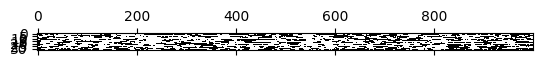

In [83]:
rho0 = 1

x0 = np.zeros(n)
x0[list(random.sample(range(n), int(rho0 * n)))] = 1

gamma = 0.1
b1 = 0.04

contagion_function = lambda nu, b: 1 - (1 - b) ** nu
c1 = contagion_function(np.arange(n), b1)

x1 = contagion_process(A, gamma, c1, x0, tmin=0, tmax=1000, random_seed=None)

plt.spy(x1.T)

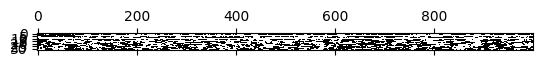

In [85]:
tau = 2
b2 = 0.2

contagion_function = lambda nu, tau, b: b * (nu >= tau)
c2 = contagion_function(np.arange(n), tau, b2)

x2 = contagion_process(A, gamma, c2, x0, tmin=0, tmax=1000, random_seed=None)

plt.spy(x2.T)

0.4356619024129945
Acceptance ratio is 0.03350387596899225


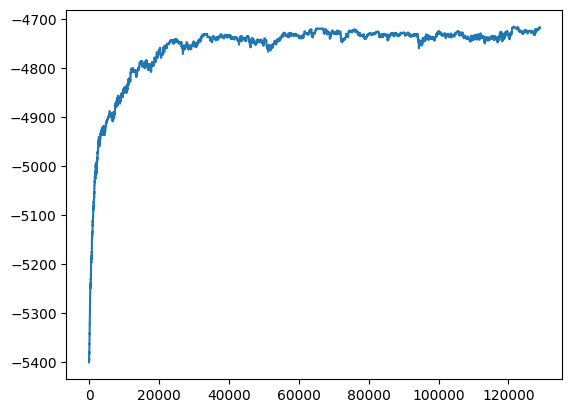

In [86]:
p_gamma = [1, 1]
p_c = np.ones((2, n))

p_rho = [1, 1]

rho0 = beta(p_rho[0], p_rho[1]).rvs()

A0 = erdos_renyi(n, rho0)

samples1, l1 = infer_adjacency_matrix(
    x1, A0, p_rho, p_c, nsamples=100, burn_in=30000, skip=1000, return_likelihood=True
)

plt.plot(l1)

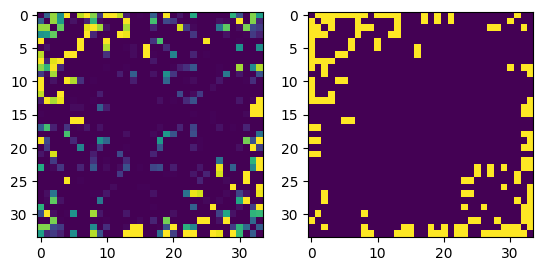

In [87]:
p = np.mean(samples1, axis=0)
plt.subplot(121)
plt.imshow(p, cmap="viridis", vmin=0, vmax=1)
plt.subplot(122)
plt.imshow(A, vmin=0, vmax=1)

Acceptance ratio is 0.022372093023255813


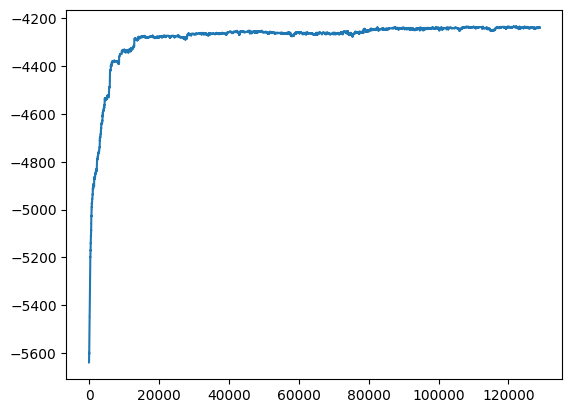

In [93]:
p_gamma = [1, 1]
p_c = np.ones((2, n))

p_rho = [1, 1]

rho0 = beta(p_rho[0], p_rho[1]).rvs()

A0 = erdos_renyi(n, rho0)

samples2, l2 = infer_adjacency_matrix(
    x2, A0, p_rho, p_c, nsamples=100, burn_in=30000, skip=1000, return_likelihood=True
)

plt.plot(l2)

In [94]:
gamma1 = np.zeros(samples1.shape[0])
cf1 = np.zeros((samples1.shape[0], n))
for i in range(samples1.shape[0]):
    g, c = infer_dynamics(x1, samples1[i], p_gamma, p_c)
    gamma1[i] = g
    cf1[i] = c

In [101]:
gamma2 = np.zeros(samples2.shape[0])
cf2 = np.zeros((samples2.shape[0], n))
for i in range(samples2.shape[0]):
    g, c = infer_dynamics(x2, samples2[i], p_gamma, p_c)
    gamma2[i] = g
    cf2[i] = c

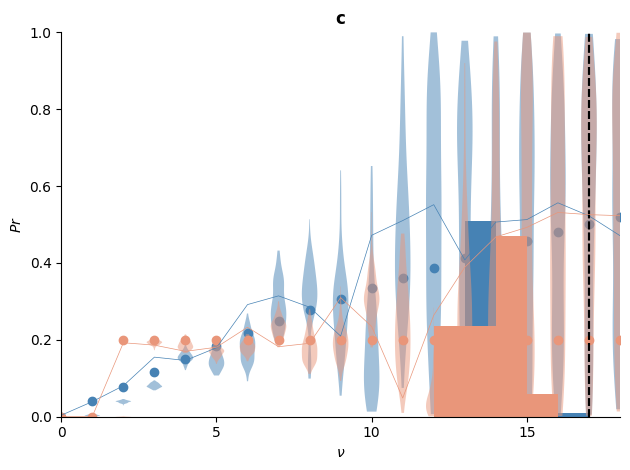

In [103]:
# import cmasher as cmr
# cmap = cmr.ember
colors = ["steelblue", "darksalmon", "mediumseagreen"]

plt.figure()
plt.title(r"$\mathbf{c}$")

# simple contagion
plt.scatter(np.arange(0, n, 1), c1, color=colors[0])

v = plt.violinplot(cf1, showextrema=False)
for vp in v["bodies"]:
    vp.set_facecolor(colors[0])
    vp.set_alpha(0.5)

kmax = np.max(degrees(A))
kmax_samples = [np.max(degrees(samples1[i])) for i in range(samples1.shape[0])]
plt.plot([kmax, kmax], [0, 1], "k--")
plt.hist(kmax_samples, bins=np.arange(0, n, 1), density=True, color=colors[0])

plt.plot(np.mean(cf1, axis=0), linewidth=0.5, color=colors[0])

# threshold contagion, tau=2
plt.scatter(np.arange(0, n, 1), c2, color=colors[1])

v = plt.violinplot(cf2, showextrema=False)
for vp in v["bodies"]:
    vp.set_facecolor(colors[1])
    vp.set_alpha(0.5)

kmax = np.max(degrees(A))
kmax_samples = [np.max(degrees(samples2[i])) for i in range(samples2.shape[1])]
plt.plot([kmax, kmax], [0, 1], "k--")
plt.hist(kmax_samples, bins=np.arange(0, n, 1), density=True, color=colors[1])

plt.plot(np.mean(cf2, axis=0), linewidth=0.5, color=colors[1])

plt.xticks(np.arange(0, cf2.shape[1], 5))
plt.xlabel(r"$\nu$")
plt.ylabel(r"$Pr$")


plt.xlim([0, kmax + 1])
plt.ylim([0, 1])

sns.despine()
plt.tight_layout()
plt.show()